[![GitHub](https://badgen.net/badge/icon/github?icon=github&label)](https://github.com/liushiru/End-to-end-ASR-Pytorch)

# Project Members

### Module Code: **CS5242** 

#### Semester: AY2021-22 Sem 1

#### Group 40

- Liu Shiru (A0187939A)
- Lim Yu Rong, Samuel (A0183921A)
- Yee Xun Wei (A0228597L)


# **README: Important Notes**

This project can **NOT** be trained or run in this notebook. This is because it was forked from a project repository and has a fair amount of setup. Refer to [our Github fork](https://github.com/liushiru/End-to-end-ASR-Pytorch "Our fork") for the full project.

---

To run this project:
1. Clone the repository.
2. Install requirements via `~/requirements.txt`.

## Dataset

Data is collected from the [Ted2srt webpage](https://ted2srt.org "Ted2srt Homepage").

Run `python3 scraper/preprocess.py` from root direcory to scrape and generate dataset.
The script will:
1. Scrape data from website.
2. Preprocess the data
3. Split the data into train-dev-test sets.

Scraped data is saved at `scraper/data/`, processed data will be saved to `data/`.
Alternatively, download data [here](https://nusu-my.sharepoint.com/:u:/g/personal/e0674581_u_nus_edu/EdCosjueRfVIm2kQK3RKBdYBrtlVWU8hsBzcjG7cb9Uo3w?e=fkWh09).


## Training

To train each model:

1. In the root directory, run the command `python3 main.py --config config/<dataset>/<config_file>.yaml --njobs 8`.

### Configuration Files

To use our dataset, set `<dataset>` as `ted` to use scraped data, or `libri` to use public data from [OpenSRL](https://www.openslr.org/12/).

Configuration files are stored as:

#### Train Extractors

| Extractor | Classifier | Configuration file |
|-----------|------------|--------------------|
| MLP       | RNN        | mlp_rnn.yaml       |
| CNN       | RNN        | cnn_rnn.yaml       |
| ANN       | RNN        | ann_rnn.yaml       |
| RNN       | RNN        | rnn_rnn.yaml       |

#### Train Classifiers

| Extractor | Classifier | Configuration file |
|-----------|------------|--------------------|
| CNN       | MLP        | cnn_mlp.yaml       |
| CNN       | CNN        | cnn_cnn.yaml       |
| CNN       | ANN        | cnn_ann.yaml       |

**We advise that a Linux machine should be used**, since some elements in the project may be buggy when used with Windows or even MacOS.

Further information can be found in `~/README.md`.

---

# Problem Statement and Motivation

The Internet of Things (IoT) is becoming relevant in daily life as a natural interface for literate and illiterate users. One important feature of IoT is its ability to provide a hands-free solution for navigating daily tasks: e.g., being able to drive and simultaneously give commands to an IoT device. Speech recognition technology is therefore a key step in the field of IoT.

**Automatic Speech Recognition (ASR)** is traditionally done through a Gaussian Mixture Model-Hidden Markov Model process. However, the rise of Neural Networks (NNs) has completely changed the field of ASR. Most modern ASR software is built on a combination of different NN structures. For this project, we therefore aim to study the performance of individual end-to-end NN structures (e.g. MLP, RNN) independently in this task, to evaluate their strengths and compare them.

Specifically, we aim to test the effectiveness of 4 types of NN architectures (MLP, CNN, RNN, ANN) in correctly parsing audio sentences of variable length. An expected input would be an audio recording of “This is a test sentence”, and the corresponding expected output would be the text “This is a test sentence”.

The codebase used in this report is forked from the [End-to-end-ASR repository](https://github.com/Alexander-H-Liu/End-to-end-ASR-Pytorch "End-to-end-ASR GitHub") by Alexander Liu.

# Data Collection

### Data Source

Data was collected from the [Ted2srt webpage](https://ted2srt.org "Ted2srt Homepage"). 

Each talk is originally presented as a video, with a single speaker talking. The videos are typically several minutes long.

Ted2srt provides download links for the video, as well as timestamp-annotated transcripts (i.e. SRTs) for most of its videos. These can be seen in the sidebar of [this sample talk](https://ted2srt.org/talks/anil_seth_how_your_brain_invents_your_self "Sample TED Talk"), for example.

---

### Scraper Inputs/Outputs

The two outputs of the scraper are:
- Audio file containing speech
- SRT text file containing timestamp-annotated transcript

Since no audio download link is provided, the scraper scrapes the lowest-quality video, and subsequently converts it into an audio file. The video file is deleted, to save storage space. See the function `download_and_save_video_file()`.

The SRT transcript can be scraped normally. See the function `download_and_save_srt_transcript_text()`. Refer to the 'Data Preprocessing' section for more details on its format.

Any talk which does not contain either the video or the SRT will not be scraped.

---

### Scraper code description

`generate_all_srt_video_urls()` takes advantage of a URL-generation hack to generate any number of ted2srt URLs.

`scrape_data_from_srt_url()`, `download_and_save_video_file()`, and `download_and_save_srt_transcript_text()` all use **BeautifulSoup** to parse the webpage, and the **requests** module to get data from the webpage.

The files downloaded are saved to a `data` folder and named after the title of the TED Talk.

The code for the scraper is shown below.


In [ ]:
from bs4 import BeautifulSoup
from moviepy import editor
import requests
from urllib import request, error

from ast import literal_eval
import logging
import os
import shutil
import transcript

os.chdir(os.path.dirname(__file__))

# Logger setup
logger = logging.getLogger()
logging.basicConfig(level="INFO", format="%(levelname)s: %(filename)s: %(message)s")

# Storage locations
DATA_STORAGE_ROOT = os.path.join(os.getcwd(), "data")

# Scraper constants
TED_SRT_HOMEPAGE = "https://ted2srt.org/"
TED_SRT_TALKS = "talks/"
TED_SRT_TALKPAGE = TED_SRT_HOMEPAGE + TED_SRT_TALKS


def main(number_of_talks=200, starting_video_id=100):
    if not os.path.isdir(DATA_STORAGE_ROOT):
        try:
            os.makedirs(DATA_STORAGE_ROOT)
        except FileNotFoundError:
            logging.error("Unable to create data storage folder.")
            raise Exception("Ensure that the current working directory is set to the project root.")

    _number_of_talks = number_of_talks  # Number of talks to attempt to scrape from
    _starting_video_id = starting_video_id  # Start retrieving from this video id

    logging.info("Parsing audio files with SRT transcripts from TED2SRT website...")
    video_urls = generate_all_srt_video_urls(TED_SRT_TALKPAGE, _number_of_talks, starting_video_id=_starting_video_id)
    for url in video_urls:
        scrape_data_from_srt_url(url)


## Code that handles scraping from the TED2SRT website


def generate_all_srt_video_urls(base_url, number_of_urls, starting_video_id=1):
    """
    Generates a list of urls to attempt to scrape from. This is designed to work specifically for the TED2SRT page.
    This method will not check whether the links are valid. It will only generate the required links.

    This method works because the TED2SRT page also stores videos mapped to their id. For example, visiting the webpage
    "homepage/talks/1" returns the 1st video in id.

    :param base_url: The base url of the TED2SRT talks page.
    :param number_of_urls: The number of urls to generate.
    :param starting_video_id: The starting video id, which defaults to the 1st video.
    :return: Returns a list of urls.
    """
    logging.info(f"Generating {number_of_urls} starting from video id {starting_video_id}...")
    logging.warning("Many of these links might not work. Consider changing the value of _number_of_talks in line 52.")
    return [base_url + str(video_id) for video_id in range(starting_video_id, starting_video_id + number_of_urls)]


# TED2SRT specific page constants
VIDEO_NAME_KEY = "slug"

VIDEO_DOWNLOAD_SUB_URL_KEY = "mediaSlug"
START_OF_AUDIO_DOWNLOAD_URL = "https://download.ted.com/talks/"
END_OF_AUDIO_DOWNLOAD_URL = "-320k.mp4"

VIDEO_SRT_ID_SUB_URL_KEY = "id"
START_OF_SRT_TRANSCRIPT_URL = "https://ted2srt.org/api/talks/"
END_OF_SRT_TRANSCRIPT_URL = "/transcripts/download/srt?lang=en"


def scrape_data_from_srt_url(url):
    """
    Attempts to scrape the audio file and SRT transcript from the given webpage.
    Specifically written to scrape data from the TED2SRT page (root: https://ted2srt.org/).

    If either the audio file or the SRT transcript does not exist, then this method will not scrape anything.
    Otherwise, the data will be saved to a folder marked by the url.
    :param url: The url to scrape data from.
    :return: No return value.
    """
    logger.info(f"\n\nScraping from url: <{url}>")
    response = requests.get(url)
    page_soup = BeautifulSoup(response.text, "html.parser")

    # Identify the metadata object and parse the key phrases needed for video and SRT download
    talk_metadata_script = page_soup.select("script")
    if not talk_metadata_script:
        logging.warning(f"The url {url} is invalid or has no metadata object. Continuing...")
        return

    talk_metadata_string = talk_metadata_script[0].string
    talk_metadata_object = literal_eval(talk_metadata_string.split(" = ")[1])

    srt_download_keyword = str(talk_metadata_object[VIDEO_SRT_ID_SUB_URL_KEY])
    video_download_keyword = str(talk_metadata_object[VIDEO_DOWNLOAD_SUB_URL_KEY])
    name_of_video = str(talk_metadata_object[VIDEO_NAME_KEY])

    srt_download_url = START_OF_SRT_TRANSCRIPT_URL + srt_download_keyword + END_OF_SRT_TRANSCRIPT_URL
    video_download_url = START_OF_AUDIO_DOWNLOAD_URL + video_download_keyword + END_OF_AUDIO_DOWNLOAD_URL

    saved_folder_path = os.path.join(DATA_STORAGE_ROOT, name_of_video)

    success_status = download_and_save_srt_transcript_text(srt_download_url, saved_folder_path)
    if not success_status:
        return

    download_and_save_video_file(video_download_url, saved_folder_path)


# Video constants
VIDEO_FILE_EXTENSION = "video.mp4"
AUDIO_FILE_EXTENSION = "audio.mp3"
SRT_TRANSCRIPT_FILE_EXTENSION = "srt_transcript.txt"


def download_and_save_video_file(video_download_url, path_to_save_to):
    """
    Downloads a video file, given its url link. Converts the video file to audio. Saves the file to the required folder.
    Specifically designed for the TED2SRT website. Note that no audio download exists. Therefore, the video must be
    downloaded first, and then converted into audio. To save space, the video file is then deleted.
    :param video_download_url: The url to download the video from.
    :param path_to_save_to: The folder name to save this file to.
    :return: Returns True if the download was successful, and False otherwise.
    """
    if not os.path.isdir(path_to_save_to):
        os.mkdir(path_to_save_to)

    video_file_saved_location = os.path.join(path_to_save_to, VIDEO_FILE_EXTENSION)
    try:
        _, _ = request.urlretrieve(video_download_url, filename=video_file_saved_location)
        logger.info("Video file saved.")
    except error.HTTPError:
        logger.warning("No video file of lowest quality found. Deleting this specific data folder...")
        srt_transcript_file_saved_location = os.path.join(path_to_save_to, SRT_TRANSCRIPT_FILE_EXTENSION)

        if os.path.isfile(srt_transcript_file_saved_location):
            shutil.rmtree(path_to_save_to)

        if os.path.isdir(path_to_save_to):
            os.rmdir(path_to_save_to)

        return False

    logger.info("Converting video.mp4 file to audio.mp3 file...")
    audio_file_saved_location = os.path.join(path_to_save_to, AUDIO_FILE_EXTENSION)

    video = editor.VideoFileClip(video_file_saved_location)
    audio = video.audio
    audio.write_audiofile(audio_file_saved_location, verbose=False, logger=None)
    video.close()

    os.remove(video_file_saved_location)
    logging.info("Audio file saved. Video file deleted.")
    return True


def download_and_save_srt_transcript_text(srt_transcript_url, path_to_save_to):
    """
    Saves the transcript text to the required folder as a file. This is specifically designed to work with the TED2SRT
    website.
    :param srt_transcript_url: The url to download the srt transcript from.
    :param path_to_save_to: The folder name to save this file to.
    :return: Returns True if the download was successful, and False otherwise.
    """
    if not os.path.isdir(path_to_save_to):
        os.mkdir(path_to_save_to)

    srt_transcript_file_saved_location = os.path.join(path_to_save_to, SRT_TRANSCRIPT_FILE_EXTENSION)
    try:
        _, _ = request.urlretrieve(srt_transcript_url, filename=srt_transcript_file_saved_location)
        
        # Check for SRT accuracy before downloading audio
        srt_is_accurate = transcript.check_srt_accuracy(srt_transcript_file_saved_location)
        if not srt_is_accurate:
            logger.warning("SRT transcript not accurate. Deleting this specific data folder...")
            shutil.rmtree(path_to_save_to)
            return False

        logger.info("SRT transcript saved.")
        return True
    except error.HTTPError:
        logger.warning("No SRT transcript found. Deleting this specific data folder...")
        audio_file_saved_location = os.path.join(path_to_save_to, VIDEO_FILE_EXTENSION)

        if os.path.isfile(audio_file_saved_location):
            shutil.rmtree(path_to_save_to)

        if os.path.isdir(path_to_save_to):
            os.rmdir(path_to_save_to)

        return False


main()


# Data Preprocessing

Preprocess scraped data to input into `Dataset` and `DataLoader`. Includes data cleaning, cutting audio into multiple audio slices according to SRT annotated time and prepare label for each audio slice.

---

### Data Preprocessing Inputs/Outputs

- Input from scraped audio files and SRT.
- Output preprocessed ready dataset for ASR.

---

### Data Preprocessing Descriptions

Symbols are removed from label and converted to lowercase.

Data that are less accurate are removed. Checking done for SRT that starts at the same time (e.g. `00:00:12,820 --> 00:00:14,820`). SRT that does not include introduction music time is filtered. Laughter and applause is removed.

Raw SRT snippet
```
1
00:00:12,312 --> 00:00:14,493
Six months ago, I got an email

2
00:00:14,493 --> 00:00:15,900
from a man in Israel
```
converted to
```
<audio_id>-1 six months ago i got an email
<audio_id>-2 from a man in israel
```
and stored at `<audio_id>.trans.txt`. Corresponding sliced audio files are named `<audio_id>_<audio_index>.mp3`.

After `build_dataset()` has preprocessed the data, the data is split into  train-dev-test sets.

In [ ]:
import os
from joblib import Parallel, delayed
from os.path import join
from pathlib import Path
import random
import shutil

import scraper
import remove_applause
import re
import subprocess
import num2words
import pydub
from pydub import AudioSegment
from tqdm import tqdm
import logging
logger = logging.getLogger()
logging.basicConfig(level="INFO", format="%(levelname)s: %(filename)s: %(message)s")


random.seed(42)
AUDIO_EXTENSION = 'mp3'
os.chdir(os.path.dirname(__file__))
corpus_path = '../data/TedSrt'
txt_norm = 'tedsrt-norm.txt'
txt_vocab = 'tedsrt-vocab.txt'
processed_data_path = join(corpus_path, 'processed_data') # store all data in this folder before splitting
txt_norm_path = join(corpus_path, txt_norm)
txt_vocab_path = join(corpus_path, txt_vocab)

src_path = 'data/' # raw data source
ratio=[.6, .2, .2] # train test split

# filter audio and srt
duration_diff = 7 # seconds
repeated_occurrence = 50



def clean_text(text):
    '''
    Text processing to clean text before saving as label
    to lowercase, convert years to words, convert digits to words, remove symbols
    '''
    text = text.lower().strip('\n')
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join([num2words.num2words(i, to='year') if (i.isdigit() & (len(i) == 4)) else i for i in text.split()]) # year to words
    text = ' '.join([num2words.num2words(i) if i.isdigit() else i for i in text.split()]) # num to words
    text = re.sub(' +', ' ', text) # remove redundant spaces
    text = text.replace('-', ' ')
    return text

def normalize_text(text):
    '''
    Text processing to normalize text for language model training
    should transform word numeral to numeric, normalize date formats, lemmatization; most not implemented currently
    '''
    text = text.lower().strip('\n')
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(' +', ' ', text) # remove redundant spaces
    text = text.replace('-', ' ')
    return text

def to_ms(string):
    '''
    Convert string '00:00:00,000' to milliseconds
    to be used for audio slicing
    '''
    string = string.replace(',','')
    hour, minute, second = string.split(':')
    second = int(second)
    second += int(hour) * 3600 * 1000
    second += int(minute) * 60 * 1000
    second = second
    return second

def txt_to_trans(txt_file, file_name):
    '''
    Convert txt file to transcript format ready to be read into Dataset
    lines formatted as 'filename-idx text_label'
    return lines and time_slices
    '''
    file = open(txt_file, 'r')
    lines = file.readlines()
    file.close()
    
    transcript = [] # label for audio
    txt_src = [] # label for language model
    time_slices = []

    for i in range(len(lines)):
        idx = re.search('^[\d]+$', lines[i].strip('\ufeff'))
        if idx:
            idx = idx[0]
            time_frame = re.findall('[0-9]{2}:[0-9]{2}:[0-9]{2},[0-9]{3}', lines[i+1])
            if time_frame:
                start, end = to_ms(time_frame[0]), to_ms(time_frame[1])
                time_slices.append((idx, (start, end)))

                audio_label = lines[i+2]
                audio_label = clean_text(audio_label)
                new_line = f"{file_name}-{idx} {audio_label}"
                transcript.append(new_line)
                
                lm_label = normalize_text(audio_label)
                txt_src.append(lm_label)
                
    return transcript, time_slices, txt_src

def save_txt(txt, output_path):
    '''
    Save transcript to output_path
    '''
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))

    with open(output_path, 'a+') as f:
        for line in txt:
            f.write(f"{line}\n")
        f.close()

def check_ms_accuracy(time_slices):
    '''
    Check whether srt is accurate, remove those not accurate to milliseconds, check repeated occurrence of 820
    '''
    for time_slice in time_slices:
        occurrence_820 = sum(1 for elem in time_slices if elem[1][0] % 1000 == 820)
    if occurrence_820 > repeated_occurrence:
        return occurrence_820
    return 0

def check_intro_timing(audio_duration, audio_srt_duration):
    '''
    Check whether srt matches audio, remove those without taking water drop intro into account
    '''
    duration_diff = audio_duration - audio_srt_duration
    if duration_diff > duration_diff:
        return duration_diff
    return 0

def build_dataset(src_path=src_path, sample=100):
    '''
    Build dataset from raw data scraper/data/
    split audio into slices
    convert srt to trans.txt ready for training
    '''
    shutil.rmtree(corpus_path, ignore_errors=True)
    folders = os.listdir(src_path)[:100]
    for idx, curr_folder in enumerate(tqdm(folders, desc="Building dataset from scraped data")):
        file_name = str(idx) #save the transcript as num, can be changed to folder name
        output_path = join(processed_data_path, file_name)
        txt_output_path = join(output_path, file_name + '.trans.txt')
                
        try:
            txt_path = list(Path(join(src_path, curr_folder)).rglob('*.txt'))[0]
            audio_path = list(Path(join(src_path, curr_folder)).rglob('*.' + AUDIO_EXTENSION))[0]
        except:
            tqdm.write(f'Data not complete {idx} {curr_folder}')
            continue
        transcript, time_slices, txt_src = txt_to_trans(txt_path, file_name)
        
        audio_file = AudioSegment.from_file(audio_path, AUDIO_EXTENSION)
        
        # check timing accuracy by milliseconds
        ms_not_accurate = check_ms_accuracy(time_slices)
        if ms_not_accurate:
            shutil.rmtree(output_path, ignore_errors=True)
            continue
        
        # check timing of audio intro
        audio_duration = audio_file.duration_seconds
        audio_srt_duration = time_slices[-1][-1][-1] / 1000
        intro_not_matched = check_intro_timing(audio_duration, audio_srt_duration)
        if intro_not_matched:
            shutil.rmtree(output_path, ignore_errors=True)
            continue
        
        # writing output
        save_txt(transcript, txt_output_path)
        save_txt(txt_src, txt_norm_path)
        for idx, time_slice in time_slices:
            audio_slice = audio_file[time_slice[0]:time_slice[1]]
            audio_output_path = join(output_path, f"{file_name}-{idx}.{AUDIO_EXTENSION}")
            audio_slice.export(audio_output_path, format=AUDIO_EXTENSION)
        
        tqdm.write(f'Successfully created {idx} {curr_folder}')

def move_folders(folders, source, destination):
    '''
    Move a list of folders from source to destination
    '''
    logger.info(f'{destination.split("/")[-1]}: {folders}')
    for folder in folders:
        shutil.move(join(source, folder), join(destination, folder))

def split_dataset(ratio=[.6, .2, .2]):
    '''
    Split dataset to train dev test according to ratio
    '''
    folders = os.listdir(processed_data_path)
    folders.sort()
    random.shuffle(folders)

    split_1 = int(ratio[0] * len(folders))
    split_2 = int((ratio[0] + ratio[1]) * len(folders))

    move_folders(folders[:split_1], processed_data_path, join(corpus_path, 'train'))
    move_folders(folders[split_1:split_2], processed_data_path, join(corpus_path, 'dev'))
    move_folders(folders[split_2:], processed_data_path, join(corpus_path, 'test'))
    shutil.rmtree(processed_data_path, ignore_errors=True)


def main():
    print('Scraping data...')
    scraper.main(number_of_talks=500, starting_video_id=2000) # 1000-1500

    print('\nStart preprocessing...')
    build_dataset(src_path, sample=100)
    split_dataset(ratio=ratio)

    print("\nRemoving laughter and applause audio files...")
    remove_applause.main(corpus_path)


main()

## PyTorch Datasets

`TedDataset` maps the sliced audio files and their corresponding labels.

`TedDataset` reads all audio files and search for corresponding labels stored at `<audio_id>.trans.txt`.


In [ ]:
from tqdm import tqdm
from pathlib import Path
from os.path import join, getsize
from ntpath import basename
from joblib import Parallel, delayed
from torch.utils.data import Dataset

# Additional (official) text src provided
OFFICIAL_TXT_SRC = ['tedsrt-lm-norm.txt']
# Default num. of threads used for loading TedSrt
READ_FILE_THREADS = 1
# Default audio extension
AUDIO_EXTENSION = 'mp3'


def read_text(file):
    '''Get transcription of target mp3 file, 
       it's somewhat redundant for accessing each txt multiplt times,
       but it works fine with multi-thread'''
    src_file = '-'.join(file.split('-')[:-1])+'.trans.txt'
    idx = basename(file).split('.')[0]

    with open(src_file, 'r') as fp:
        for line in fp:
            if idx == line.split(' ')[0]:
                return line[:-1].split(' ', 1)[1]


class TedDataset(Dataset):
    def __init__(self, path, split, tokenizer, bucket_size, ascending=False):
        # Setup
        self.path = path
        self.bucket_size = bucket_size

        # List all wave files
        file_list = []
        for s in split:
            split_list = list(Path(join(path, s)).rglob("*." + AUDIO_EXTENSION))
            assert len(split_list) > 0, "No data found @ {}".format(join(path,s))
            file_list += split_list
        # Read text
        text = Parallel(n_jobs=READ_FILE_THREADS)(
            delayed(read_text)(str(f)) for f in file_list)
        text = [tokenizer.encode(txt.upper()) for txt in text]

        # Sort dataset by text length
        self.file_list, self.text = zip(*[(f_name, txt)
                                          for f_name, txt in sorted(zip(file_list, text), reverse=not ascending, key=lambda x:len(x[1]))])

    def __getitem__(self, index):
        if self.bucket_size > 1:
            # Return a bucket
            index = min(len(self.file_list)-self.bucket_size, index)
            return [(f_path, txt) for f_path, txt in
                    zip(self.file_list[index:index+self.bucket_size], self.text[index:index+self.bucket_size])]
        else:
            return self.file_list[index], self.text[index]

    def __len__(self):
        return len(self.file_list)

# Data Exploration

#### Audio metadata of an audio slice
```
Sample Rate: 44100
Shape: (1, 84055)
Dtype: torch.float32
 - Max:          0.523
 - Min:         -0.319
 - Mean:        -0.000
 - Std Dev:      0.081
 ```

#### Audio signal


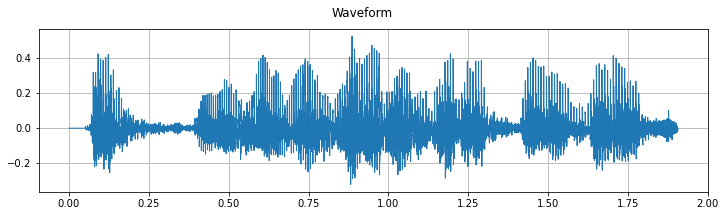



Waveform plot of sample audio signal with length of 1.9s. Duration length can obtained: `signal_frames / sample_rate`.

#### Spectrogram of raw audio signal

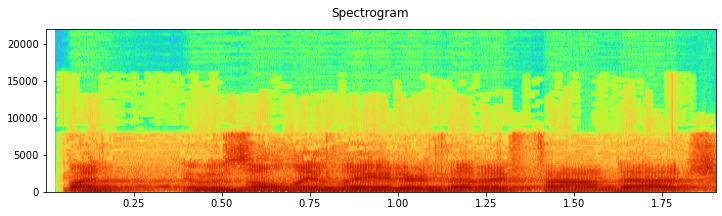

# Data Processing

Steps to compute filter banks are motivated to mimic how human perceives audio signals<sup>[[1]](#reference)</sup>.

1. Apply pre-emphasis filter on audio signal (amplify the high frequencies since high frequencies have smaller magnitude).
2. Cut signal into window frames (assume signal is stationary over a short period time).
3. Compute the power spectrum of the signal (Fourier transform) for each window.


Kaldi filter banks transformation applied on audio signals. 40 mel coefficients is kept.

In [ ]:
feat_dim = 40
waveform_trans = torchaudio.compliance.kaldi.fbank(signal, frame_length=25, frame_shift=10, num_mel_bins=feat_dim)
plot_spectrogram(waveform_trans.transpose(0, 1).detach(), title="Filter Banks", ylabel='mel bins')

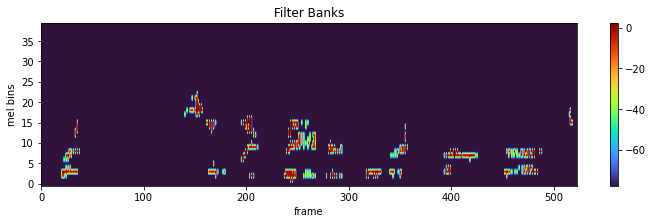

# Model Design

## Description of End-to-end-ASR model

In this project, we are training a feature extractor and classifier, that collectively classify words based on audio inputs. The feature extractor mechanism extracts features from timesteps (i.e. speech frames). This feature vector is used by the classifier to generate an output sequence of characters. The output sequence is evaluated using Connectionist Temporal Classification (CTC) Loss and Word Error Rate (WER).



### Baseline model

The combination of extractor and classifier used in the ASR-End-to-end paper is a VGGNet followed by an LSTM. We consider VGGNet to be a CNN, and LSTM to be an RNN.

The use of a CNN feature extractor is motivated by previous studies<sup>[[2]](#reference)[[3]](#reference)</sup>, and similarly for the use of an LSTM classifier<sup>[[4]](#reference)</sup>.



## Experimentation Plan


The following table describes the 7 sets of extractor-classifier combinations used in the tests. The first combination (Baseline) is used by the ASR-End-to-end paper. Apart from that, there are 6 other combinations that we can use, that involve changing either the extractor or the classifier of the original CNN-RNN combination, but not both.

##### Baseline

Model Tested | Extractor | Classifier
--- | --- | ---
Baseline | CNN | RNN

##### Change the Extractor

Model Tested | Extractor | Classifier
--- | --- | ---
MLPExtractor | MLP | RNN
RNNExtractor | RNN | RNN
ANNExtractor | ANN | RNN

##### Change the Classifier

Model Tested | Extractor | Classifier
--- | --- | ---
MLPClassifier | CNN | MLP
CNNClassifier | CNN | CNN
ANNClassifier | CNN | ANN

We cannot change both the extractor and classifier in a single test because we cannot compare it easily with the original baseline.

## Code Written

In [ ]:
# TAKE NOTE that these code elements cannot be trained within this notebook, due to the complex project ecosystem.
# Refer to the 'Important Notes' section at the start of this notebook for instructions on running the project.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

### Extractors


Extractor generates a sequence of feature vectors. Each feature vector is extracted from a small overlapped window of audio frames. Extractor transforms $x$, to high-level representation $h = (h_1, ..., h_L)$.

Extractor includes downsampling of timesteps.


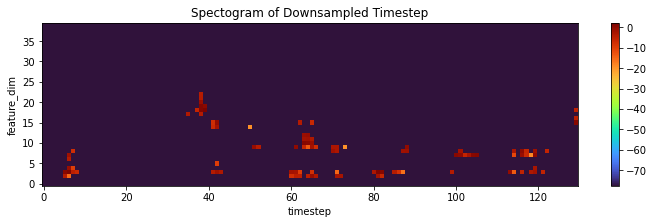

For example downsampling by a factor of 4 from 523 timesteps to 130 timesteps in RNN extractor. Downsampling is also achieved by MaxPooling of CNN extractors.

#### MLP Extractor

In [ ]:
class MLPExtractor(nn.Module):
    ''' A simple MLP extractor for acoustic feature down-sampling
    Every 4 frame will be convert to corresponding features by MLP'''

    def __init__(self, input_dim, out_dim):
        super(MLPExtractor, self).__init__()

        self.out_dim = out_dim
        self.hide_dim = input_dim * 3
        self.extractor = nn.Sequential(
            nn.Linear(input_dim, self.hide_dim),
            nn.ReLU(),
            nn.Linear(self.hide_dim, self.hide_dim),
            nn.ReLU(),
            nn.Linear(self.hide_dim, self.hide_dim),
            nn.ReLU(),
            nn.Linear(self.hide_dim, self.hide_dim),
            nn.ReLU(),
            nn.Linear(self.hide_dim, self.out_dim),
        )

    def reshape_input(self, feature, group_size):
        down_sample_len = feature.size(1) // group_size
        feature = feature[:,:down_sample_len*group_size,:]
        reshape_feature = feature.reshape(feature.size(0) * down_sample_len, group_size*feature.size(2))
        return reshape_feature


    def forward(self, feature, feat_len):
        bs = feature.size(0)
        feature = self.reshape_input(feature, group_size=4)
        raw_output = self.extractor(feature)

        reshape_output = raw_output.reshape(bs, raw_output.size(0) // bs, self.out_dim)
        return reshape_output, torch.div(feat_len,4, rounding_mode="floor")

#### RNN Extractor

Applied RNN layer on input (speech frames/ timesteps). RNN output is followed by downsampling by factor of 4.

In [ ]:
class RNNExtractor(nn.Module):
    ''' A 2-layer RNN extractor for acoustic feature down-sampling'''

    def __init__(self, input_dim, out_dim):
        super(RNNExtractor, self).__init__()

        self.out_dim = out_dim
        self.layer = nn.RNN(input_dim, self.out_dim)
        self.dp = nn.Dropout(p=0.2)
        self.linear = nn.Linear(self.out_dim, self.out_dim)

    def forward(self, feature, feat_len):

        # feat_len = feat_len//4
        feat_len = torch.div(feat_len, 4, rounding_mode='floor')
        feature, _ = self.layer(feature)
        # Normalization
        feature = self.dp(feature)
        
        # Downsample timestep
        sample_rate = 4
        if feature.shape[1] % sample_rate != 0:
            feature = feature[:, :-(feature.shape[1] % 4), :].contiguous()
        feature = feature[:, ::sample_rate, :].contiguous()

        return feature, feat_len

#### ANN Extractor

In this work we applied local self-attention layer<sup>[[5]](#reference)</sup> to replace spatial convolutions as a feature extractor. The attention is computed as follows

\begin{align}
y_{ij} = 
  \sum_{a, b \in \, \mathcal{N}_k(i, j)}
    \texttt{softmax}_{a b}\left(  q_{i j}^\top k_{a b}  \right)  v_{a b}
\end{align}

where the *queries* $q_{ij} = W_Q x_{ij}$, *keys* $k_{ab} = W_K x_{ab}$, and *values* $v_{ab} = W_V x_{ab}$ are linear transformations of the pixel in position $ij$ and the neighborhood pixels<sup>[[5]](#reference)</sup>.

In [ ]:
class ANNExtractor(nn.Module):
    ''' ANN extractor with self-attention mechanism from https://github.com/leaderj1001/Stand-Alone-Self-Attention'''

    def __init__(self, input_dim, groups=8):
        super(ANNExtractor, self).__init__()
        self.init_dim = 64
        self.hide_dim = 128
        in_channel, freq_dim, out_dim = self.check_dim(input_dim)
        self.in_channel = in_channel
        self.freq_dim = freq_dim
        self.out_dim = 640
        width = freq_dim

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, width, 3, stride=1, padding=1),
            nn.BatchNorm2d(width),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Half-time dimension
            nn.Conv2d(width, width, 3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=2),  # Half-time dimension
        )
        self.conv2 = nn.Sequential(
            AttentionConv(width, width, kernel_size=7, padding=3, groups=groups),
            nn.BatchNorm2d(width),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(width, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
        )

    def check_dim(self, input_dim):
        # Check input dimension, delta feature should be stack over channel.
        if input_dim % 13 == 0:
            # MFCC feature
            return int(input_dim/13), 13, (13//4)*self.hide_dim
        elif input_dim % 40 == 0:
            # Fbank feature
            return int(input_dim/40), 40, (40//4)*self.hide_dim
        else:
            raise ValueError(
            'Acoustic feature dimension for VGG should be 13/26/39(MFCC) or 40/80/120(Fbank) but got '+input_dim)

    def view_input(self, feature, feat_len):
        # downsample time
        # feat_len = feat_len//4
        feat_len = torch.div(feat_len, 4, rounding_mode='floor')
        # crop sequence s.t. t%4==0
        if feature.shape[1] % 4 != 0:
            feature = feature[:, :-(feature.shape[1] % 4), :].contiguous()
        bs, ts, ds = feature.shape
        # stack feature according to result of check_dim
        feature = feature.view(bs, ts, self.in_channel, self.freq_dim)
        feature = feature.transpose(1, 2)

        return feature, feat_len

    def forward(self, feature, feat_len):
        
        # Feature shape BSxTxD -> BSxCH(1)xT/4xD
        feature, feat_len = self.view_input(feature, feat_len) #downsample on time
        # Foward
        # BS x 1 x T/4 x D/4 -> BS x width x T/4 x D
        feature = self.conv1(feature)
        # BS x width x T/4 x D/4 -> BS x width x T/8 x D/2 (attention)
        feature = self.conv2(feature)

        # BS x width x T/8 x D/2 -> BS x 64 x T/8 x D/4
        feature = self.conv3(feature)
        feature = F.relu(feature)
        # BS x 64 x T/8 x D/4 -> BS x T/8 x 64 x 8D
        feature = feature.transpose(1, 2)
        # BS x T/8 x 64 x 8D -> BS x T/8 x 8D
        feature = feature.contiguous().view(feature.shape[0], feature.shape[1], -1)

        return feature, feat_len


class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat((k_out_h + self.rel_h, k_out_w + self.rel_w), dim=1)

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)

### Classifiers

Classifier generates an output sequence $(y_1, . . . , y_T)$ from input $h$. $h$ is the output of the extractor. The classifier's output $y$ is a sequence of word tokens. The sequence $y$ is expected to include a dimension of the same size as $h$.


#### MLP Classifier

The MLPClassifier class uses 5 linear layers. For every timeframe, the extractor map the audio fbanks feature to a latent representation. Then the MLP Classifier aims to map the latent representation to a word token prediction. 

Unlike original BiLSTM classifier that looks after timeframe from before and after, the MLP classifier is completely local. It only cares about the current timeframe. 

In [ ]:
class MLPCLassfier(nn.Module):
    def __init__(self, input_dim):
        super(MLPCLassfier, self).__init__()
        h1 = input_dim*2
        h2 = h1*2
        self.out_dim = h2*2
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, h2),
            nn.ReLU(),
            nn.Linear(h2, h2),
            nn.ReLU(),
            nn.Linear(h2, self.out_dim),
        )

    def reshape_input(self, feature, group_size):
        down_sample_len = feature.size(1) // group_size
        feature = feature[:,:down_sample_len*group_size,:]
        reshape_feature = feature.reshape(feature.size(0) * down_sample_len, group_size*feature.size(2))
        return reshape_feature


    def forward(self, feature):

        return self.classifier(feature)


#### CNN Classifier

The CNNClassifer class uses multiple convolutional layers and only one dense layer. The choice of a single dense layer was used to isolate the effectiveness of convolutional layers specifically.

The dense layer cannot be directly connected to the convolutional layers. This is because the input data is of size `(timesteps x features)`, where `features` is fixed at 1280, but `timesteps` differs between inputs. Additionally, the output vector is required to contain a dimension with size equal to `timesteps`.

A workaround for this is to apply the linear layer to each timestep separately, and output a separate value for each of the timesteps. Additionally, pooling layers should not pool along the timestep axis, since the output vector must have a dimension with size equal to `timesteps`.

In [ ]:
class CNNClassifier(nn.Module):
    """4-layer CNN classifier module."""
    
    def __init__(self, input_dim):
        super(CNNClassifier, self).__init__()
        self.hidden_dim_1 = hidden_dim_1 = input_dim // 64
        self.hidden_dim_2 = hidden_dim_2 = hidden_dim_1 * 2

        self.out_dim = input_dim // 4

        conv_hyperparams = {
            "kernel_size": (3,3),
            "dilation": (1,1),
            "stride": (1,1),
            "padding": (1,1),
        }

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_dim_1, **conv_hyperparams)
        self.conv2 = nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, **conv_hyperparams)
        self.conv3 = nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, **conv_hyperparams)
        self.conv4 = nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, **conv_hyperparams)
        self.dense = nn.Linear(hidden_dim_2 * self.out_dim, self.out_dim)
        self.pool = nn.MaxPool2d((1, 2))

    def reshape_input(self, feature, group_size):
        down_sample_len = feature.size(1) // group_size
        feature = feature[:,:down_sample_len*group_size,:]
        reshape_feature = feature.reshape(feature.size(0) * down_sample_len, group_size*feature.size(2))
        return reshape_feature

    def forward(self, feature):
        # Input size is varied - size is N timesteps x 1280 features. Batch size = 1 and number of input channels = 1.
        # Therefore, inputs must be unsqueezed.
        feature = feature.unsqueeze(dim=0).unsqueeze(dim=1)

        # Format: input_channels x timesteps x features --> output_channels x new_timesteps x new_features
        feature = self.conv1(feature)  # 1 x N x 1280 --> 24 x N x 1280
        feature = F.relu(feature)
        feature = self.conv2(feature)  # 24 x N x 1280 --> 24 x N x 1280
        feature = F.relu(feature)
        feature = self.pool(feature)  # 24 x N x 1280 --> 24 x N x 640
        feature = self.conv3(feature)  # 24 x N x 640 --> 48 x N x 640
        feature = F.relu(feature)
        feature = self.conv4(feature)  # 48 x N x 640 --> 48 x N x 640
        feature = F.relu(feature)
        feature = self.pool(feature)  # 48 x N x 640 --> 48 x N x 320

        feature = feature.transpose(0, 1)  # 48 x N x 320 --> N x 48 x 320
        feature = feature.view(-1, self.hidden_dim_2 * self.out_dim) # N x 48 x 320 --> N x (48 x 320)
        feature = torch.stack([
            self.dense(feature[index].unsqueeze(dim=0)) 
            for index in range(feature.size()[0])])  # N x (48 x 320) --> N x 320
        feature = feature.transpose(0, 1)  # N x 320 --> 320 x N
        return feature

#### ANN Classifier

The ANNClassifier class uses a single Self-Attention layer (referencing [this implementation](https://github.com/leaderj1001/Stand-Alone-Self-Attention/blob/master/attention.py "Self-Attention layer implementation") of a Self-Attention layer). The implementation is identical to the one used in the ANNExtractor.

The ANNClassifier only uses a single dense layer. This is to isolate the effectiveness of the Self-Attention layer.

However, because the Self-Attention layer is extremely space-intensive, only a single Self-Attention layer can be used, and pooling is applied prior to the data being forwarded to it.

Additionally, the ANNClassifier's dense layer faces the same issue as the CNNClassifier - the input data is of unknown size, and therefore the dense layer is applied to each timestep individually.

In [ ]:
class ANNClassifier(nn.Module):
    """ANN classifier with Self-Attention module from https://github.com/leaderj1001/Stand-Alone-Self-Attention/blob/master/attention.py."""

    def __init__(self, input_dim):
        super(ANNClassifier, self).__init__()
        self._pool_value = 4
        self.hidden_dim_1 = hidden_dim_1 = 20
        self.linear_input_dim = hidden_dim_1 * input_dim // self._pool_value
        self.out_dim = 80

        attn_hyperparams = {
            "kernel_size": 3,
            "padding": 1,
        }

        self.attn = AttentionConv(1, hidden_dim_1, **attn_hyperparams)
        self.dense = nn.Linear(self.linear_input_dim, self.out_dim)
        self.pool = nn.MaxPool2d((1, self._pool_value))

    def reshape_input(self, feature, group_size):
        down_sample_len = feature.size(1) // group_size
        feature = feature[:,:down_sample_len*group_size,:]
        reshape_feature = feature.reshape(feature.size(0) * down_sample_len, group_size*feature.size(2))
        return reshape_feature

    def forward(self, feature):
        # Input size is varied - size is N timesteps x 1280 features. Batch size = 1 and number of input channels = 1.
        # Therefore, inputs must be unsqueezed.
        feature = feature.unsqueeze(dim=0).unsqueeze(dim=1)

        # Format: output_channels x new_timesteps x new_features

                                                   # 1 x N x 1280
        feature = self.pool(feature)               # 1 x N x 320
        feature = self.attn(feature)               # 20 x N x 320
        feature = F.relu(feature)

        feature = feature.transpose(0, 1)  # N x 20 x 320
        feature = feature.view(-1, self.linear_input_dim)   # N x (20 x 320)
        feature = torch.stack([
            self.dense(feature[index].unsqueeze(dim=0)) 
            for index in range(feature.size()[0])])  # N x 80
        feature = feature.transpose(0, 1)  # 80 x N

        return feature


class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat((k_out_h + self.rel_h, k_out_w + self.rel_w), dim=1)

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)



# Experiment Results


2 separate datasets were used for training - the original Librispeech dataset used in the forked repository, and our own scraped TedSrt dataset. This is because the models all performed poorly on our TedSrt dataset, leading us to believe that our dataset was flawed. Training on the Librispeech dataset instead showed a significant difference in performance between models.

### TedSrt

> 200 MB of audio data was scraped from [Ted2Srt](https://ted2srt.org/). We tried training on 1 GB of dataset but the results were roughly similar.

Baseline Model

| Extractor | Classifier | CTC-WER | CTC-Loss |
|-----------|------------|---------|----------|
| CNN       | RNN        | 0.92    | 6.56     |

Comparing performance of Extractor

| Extractor | Classifier | CTC-WER | CTC-Loss |
|-----------|------------|---------|----------|
| MLP       | RNN        | 0.99    | 6.58     |
| ANN       | RNN        | 1       | 6.92     |
| RNN       | RNN        | 0.95    | 6.53     |


Comparing performance of Classifier

| Extractor | Classifier | CTC-WER | CTC-Loss |
|-----------|------------|---------|----------|
| CNN       | MLP        | 0.90    |5.746     | 
| CNN       | CNN        | 0.95    |6.745     |
| CNN       | ANN        | 0.99    |6.98      |

---

### LibriSpeech

> This is a public dataset by [OpenSLR](https://www.openslr.org/12/). The repository is already designed to accommodate this dataset. The subset that we used for training is 6 GB in size.

Baseline Model

| Extractor | Classifier | CTC-WER | CTC-Loss |
|-----------|------------|---------|----------|
| CNN       | RNN        | 0.21926 | 1.32976  |

Comparing performance of Extractor

| Extractor | Classifier | CTC-WER | CTC-Loss |
|-----------|------------|---------|----------|
| MLP       | RNN        | 0.99    | 6.63263  |
| ANN       | RNN        | 0.9954  | 6.87     |
| RNN       | RNN        | 0.263   | 1.62     |


Comparing performance of Classifier

| Extractor | Classifier | CTC-WER | CTC-Loss |
|-----------|------------|---------|----------|
| CNN       | MLP        | 0.5884  | 4.092    |
| CNN       | CNN        | 1       | 7.031    |
| CNN       | ANN        | 0.9982  | 7.065    |


# Discussion

### Our TedSrt dataset is likely flawed

All models performed extremely poorly (WER >= 0.90) on the TedSrt dataset. It is possible that insufficient data was scraped to train the models (we tried up to 1 GB of data). 

This is a example from the best performing model trained with TedSrt:

Label Text: **AS A KID THE IDEA OF ABORTION MADE ME SO SAD THAT I KNEW IF I**

Prediction Text: **AND I WE IN THE ON**

Clearly the model overfits to the training data as shown from the picture below. The training loss reduce to zero while validation loss remains hight, so as the WER. It only learns the most frequent word and other trivial features from the training set. At the testing time, the model try to predict to the most frequent words.


 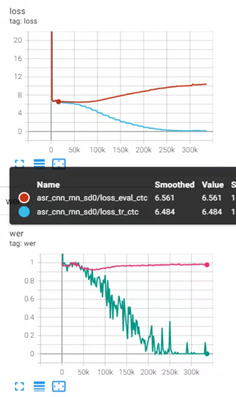


Alternatively, the quality of the data might not be good enough for training (audio quality, time annotation etc.). Due to this, we use the Librispeech dataset for a models comparison.

---

### All models performed worse than the baseline

For the Librispeech dataset, all models had greater WER and loss than the baseline. This is expected because the BiLSTM used in the baseline has long-short term memory specifically designed for better training speech-related networks, whereas our classifiers do not.

---

### The RNN-RNN and CNN-MLP networks performed quite well

For the RNN extractor, it is possible that there is a significant element of time-correlation in the audio, i.e. the features at timestep $t$ are heavily related to the features at timestep $t-1$, and somewhat related to the features at $t-2$... etc. Therefore, an RNN extractor is still quite capable of summarizing these temporal relationships, albeit less efficiently than the CNN extractor.

MLP classifier is completely local, meaning that it does not look after time frame before and after and only predicts using the information from current timeframe. The fact that it is still able to reduce the WER significantly shows that the correlation between audio and the corresponding word token is strong enough, such that the word can still be identified without temporal information. 

On the other hand, for CNN classifier, although the filters can slide over the entire audio sequence, the small filters might not be able to capture the temporal information for such a long time. Meanwhile it also loss the local information, and ends up and perform even worse the MLP.

One other possibility for why the MLP classifier performed better is because more dense layers were used. Only 1 dense layer was used for both the CNN and ANN classifiers, owing to the difficulty of having an unknown number of timesteps. This could have contributed to the success of the MLP over the other NNs.

---

### Attention Neural Networks performed very poorly

It is possible that insufficient Self-Attention layers were used. Due to hardware and compute limitations, only a single layer could fit into RAM. It is possible that, with a hardware upgrade and more Self-Attention layers, the performance could improve.


# Conclusion

This project has found that apart from the CNN-RNN baseline, the RNN-RNN and CNN-MLP models also perform adequately. The proposed reason for the RNN extractor's effectiveness is its ability to capture temporal connections better, and the proposed reason for the MLP is the presence of more dense layers and the strong correlation between the audio features and corresponding word token. However, the CNN-RNN baseline still performed the best, owing to the more sophisticated CNN and RNN networks used.

We conclude that further research on this topic can be conducted by varying the number of layers used in the models, and using that to verify or dispute the results obtained in our experimetns.

# References

<a name="reference"></a>

1. [Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html), H M Fayek.

2. [Towards End-to-End Speech Recognition with Deep Convolutional Neural Networks](https://arxiv.org/abs/1701.02720), Y. Zhang *et al*.

3. [Very Deep Convolutional Networks for End-to-End Speech Recognition](https://arxiv.org/abs/1610.03022), Y. Zhang *et al*.

4. [Advances in Joint CTC-Attention based End-to-End Speech Recognition with a Deep CNN Encoder and RNN-LM](https://arxiv.org/abs/1706.02737), T. Hori *et al*.

5. [Stand-Alone Self-Attention in Vision Models](https://arxiv.org/abs/1906.05909), P. Ramachandran *et al*.